In [23]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, auc,roc_curve, accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score



In [24]:
data=pd.read_csv("C:/Users/chenl/Data Science prep/data/employee_retention_data.csv",parse_dates=["join_date","quit_date"])
data["employee_id"]=data["employee_id"].astype("str")
data["company_id"]=data["company_id"].astype("str")
print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  object        
 1   company_id   24702 non-null  object        
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 1.3+ MB
None


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaT
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaT
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09


In [25]:
data.isnull().sum()
# quit date null have meaning

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [26]:
data.describe()

,seniority,salary,join_date,quit_date
count,24702.000000,24702.000000,24702,13510
mean,14.127803,138183.345478,2013-06-29 09:39:37.556473344,2014-05-02 17:43:38.327165184
min,1.000000,17000.000000,2011-01-24 00:00:00,2011-10-13 00:00:00
25%,7.000000,79000.000000,2012-04-09 00:00:00,2013-06-28 00:00:00
50%,14.000000,123000.000000,2013-06-24 00:00:00,2014-06-20 00:00:00
75%,21.000000,187000.000000,2014-09-17 00:00:00,2015-03-27 00:00:00
max,99.000000,408000.000000,2015-12-10 00:00:00,2015-12-09 00:00:00
std,8.089520,76058.184573,NaN,NaN


# create a table with 3 columns: day, employee_headcount, company_id.

In [27]:
# join and quit 
join=data.groupby(["company_id","join_date"])["employee_id"].count().reset_index().rename(columns={"employee_id":"new_join"})
quit=data.groupby(["company_id","quit_date"])["employee_id"].count().reset_index().rename(columns={"employee_id":"new_quit"})
# date host
days=pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
companys=sorted(data["company_id"].unique())

# join list into panda
dates=[]
company=[]
headcount=[]

for day in days:
    for comp in companys:
        total_join=sum(join[(join["join_date"]<=day) & (join["company_id"]==comp)]["new_join"])
        total_quit=sum(quit[(quit["quit_date"]<=day) & (quit["company_id"]==comp)]["new_quit"])
        dates.append(day)
        company.append(comp)
        headcount.append(total_join-total_quit)

table=pd.DataFrame({
    "day":dates,"company_id":company,"employee_headcount":headcount
})

table.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,10,0
2,2011-01-24,11,0
3,2011-01-24,12,0
4,2011-01-24,2,17


# churns analysis

In [28]:
data["duration"]=(data["quit_date"]-data["join_date"]).dt.days
data["churn"]=data["quit_date"].apply(lambda x: 0 if pd.isnull(x) else 1)
quit=data[~data["quit_date"].isnull()]
stay=data[data["quit_date"].isnull()]
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration,churn
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,1
...,...,...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaT,NaN,0
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaT,NaN,0
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,780.0,1
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1123.0,1


feature creation

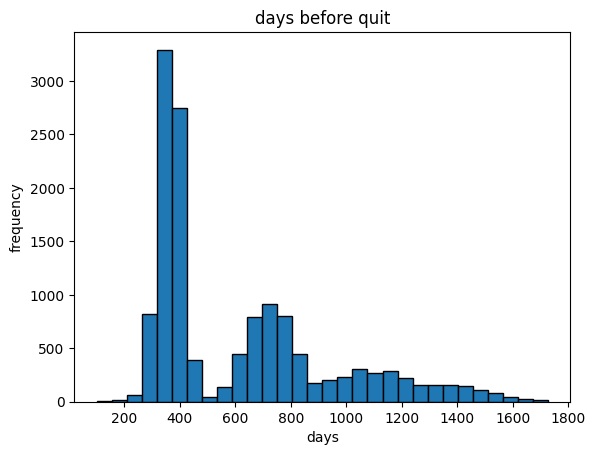

In [29]:
# stay time length
# quit["duration"]=(quit["quit_date"]-quit["join_date"]).dt.days
quit["duration"].plot(kind="hist",bins=30,edgecolor="black")
plt.xlabel("days")
plt.ylabel("frequency")
plt.title("days before quit")
plt.show()

# sns.histplot(x="duration",data=quit,bins=30, edgecolor="black")
# plt.xlabel("days")
# plt.ylabel("frequency")
# plt.title("days before quit")
# plt.show()

# if employ stay more than a year ~400 days, less likely to quit? can use it as threshold

Text(0.5, 1.0, 'xx')

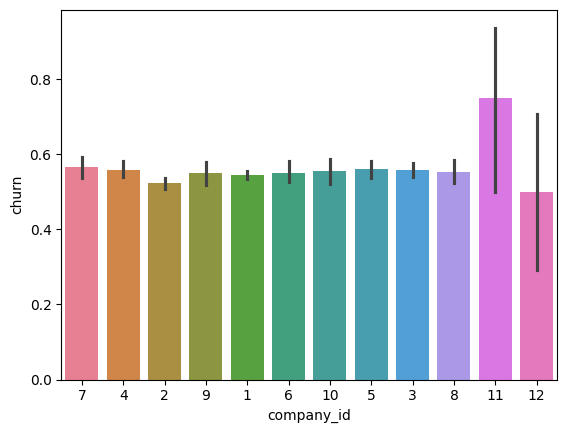

In [30]:
sns.barplot(x="company_id",y="churn",hue="company_id",data=data)
ax.set_title("xx", fontsize=16)

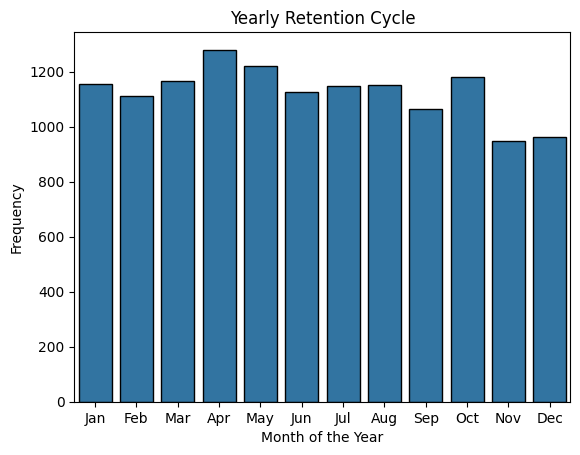

In [31]:
#quit month
#sns method
quit["join_month"] = quit["join_date"].dt.month

sns.countplot(x="join_month", data=quit, edgecolor="black")
plt.xlabel("Month of the Year")
plt.ylabel("Frequency")
plt.title("Yearly Retention Cycle")
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

In [32]:
# matplot method
# month_counts = quit["join_date"].dt.month.value_counts().sort_index()
# # Plot using Matplotlib
# plt.bar(month_counts.index, month_counts.values, edgecolor="black")
# plt.xlabel("Month of the Year")
# plt.ylabel("Frequency")
# plt.title("Yearly Retention Cycle")
# # plt.xticks(range(1, 13))  # Ensure x-axis has 1-12 for months
# plt.show()

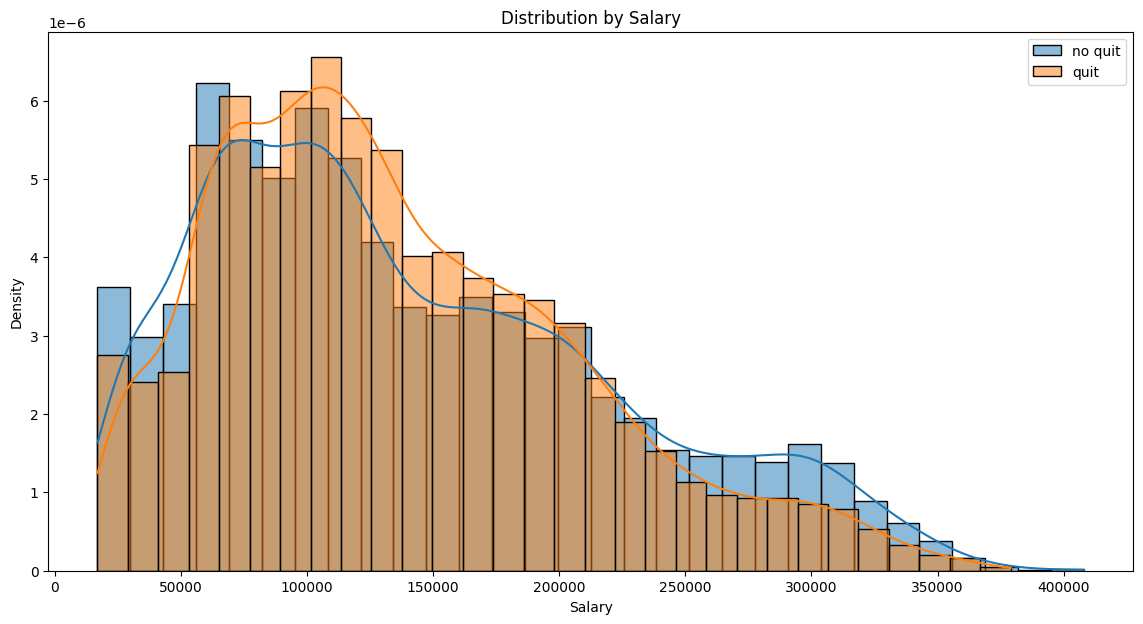

In [33]:
# salary
fig, ax = plt.subplots(figsize=(14,7))
sns.histplot(data=data[data["quit_date"].isnull()],label="no quit", x="salary", bins=30, kde=True, edgecolor="black",stat="density")
sns.histplot(data=data[~data["quit_date"].isnull()],label="quit", x="salary", bins=30, kde=True, edgecolor="black",stat="density")
plt.title("Distribution by Salary")
plt.xlabel("Salary")
plt.ylabel("Density")
plt.legend()
plt.show()

# modeling

In [34]:
# features use: company / dept / seniority / salary / join yr and month? last day is 2015-12-10
subset=data[["company_id","dept","seniority","salary","join_date","churn"]] # it's churn by 2015-12-10
subset.dtypes
# require all numeric

company_id            object
dept                  object
seniority              int64
salary               float64
join_date     datetime64[ns]
churn                  int64
dtype: object

In [35]:
# if stay more than 400, cut off line
# from datetime import datetime, timedelta
# target_date=pd.to_datetime("2015-12-10")-pd.Timedelta(days=400)
# # target_date
# subset["join_date"]=subset["join_date"].apply(lambda x: "longer_than_1yr" if x<=target_date else "shorter_than_1yr")

subset["company_id"] = subset["company_id"].astype(int)
subset["days_since_join"] = (pd.to_datetime("2015-12-10") - pd.to_datetime(subset["join_date"])).dt.days
subset

,company_id,dept,seniority,salary,join_date,churn,days_since_join
0,7,customer_service,28,89000.0,2014-03-24,1,626
1,7,marketing,20,183000.0,2013-04-29,1,955
2,4,marketing,14,101000.0,2014-10-13,0,423
3,7,customer_service,20,115000.0,2012-05-14,1,1305
4,2,data_science,23,276000.0,2011-10-17,1,1515
...,...,...,...,...,...,...,...
24697,3,customer_service,16,97000.0,2015-02-18,0,295
24698,4,engineer,10,160000.0,2015-10-26,0,45
24699,4,customer_service,11,67000.0,2013-09-03,1,828
24700,10,engineer,98,266000.0,2011-12-13,1,1458


In [36]:
# OneHot encoding
# labelEncoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
subset["dept"]=le.fit_transform(subset["dept"])
subset.dtypes

company_id                  int32
dept                        int32
seniority                   int64
salary                    float64
join_date          datetime64[ns]
churn                       int64
days_since_join             int64
dtype: object

In [37]:
# decision tree don't assume a numerical relationship of number ranking, so label encoding is prefered
X=subset.drop(columns=["churn","join_date"])
y=subset["churn"]

# train model
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=100)
clf=DecisionTreeClassifier(max_depth=4,min_samples_split=5,min_samples_leaf=5)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("accuracy", accuracy_score(y_test,y_pred))
print("classification report")
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

cv_score=cross_val_score(clf,X,y,cv=5,scoring="accuracy")
cv_score
# model seems stable with ok accuray or explaination power

accuracy 0.7965186884361085
classification report
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      3388
           1       0.80      0.84      0.82      4023

    accuracy                           0.80      7411
   macro avg       0.80      0.79      0.79      7411
weighted avg       0.80      0.80      0.80      7411

[[2536  852]
 [ 656 3367]]


array([0.79983809, 0.80368346, 0.7917004 , 0.79311741, 0.79048583])

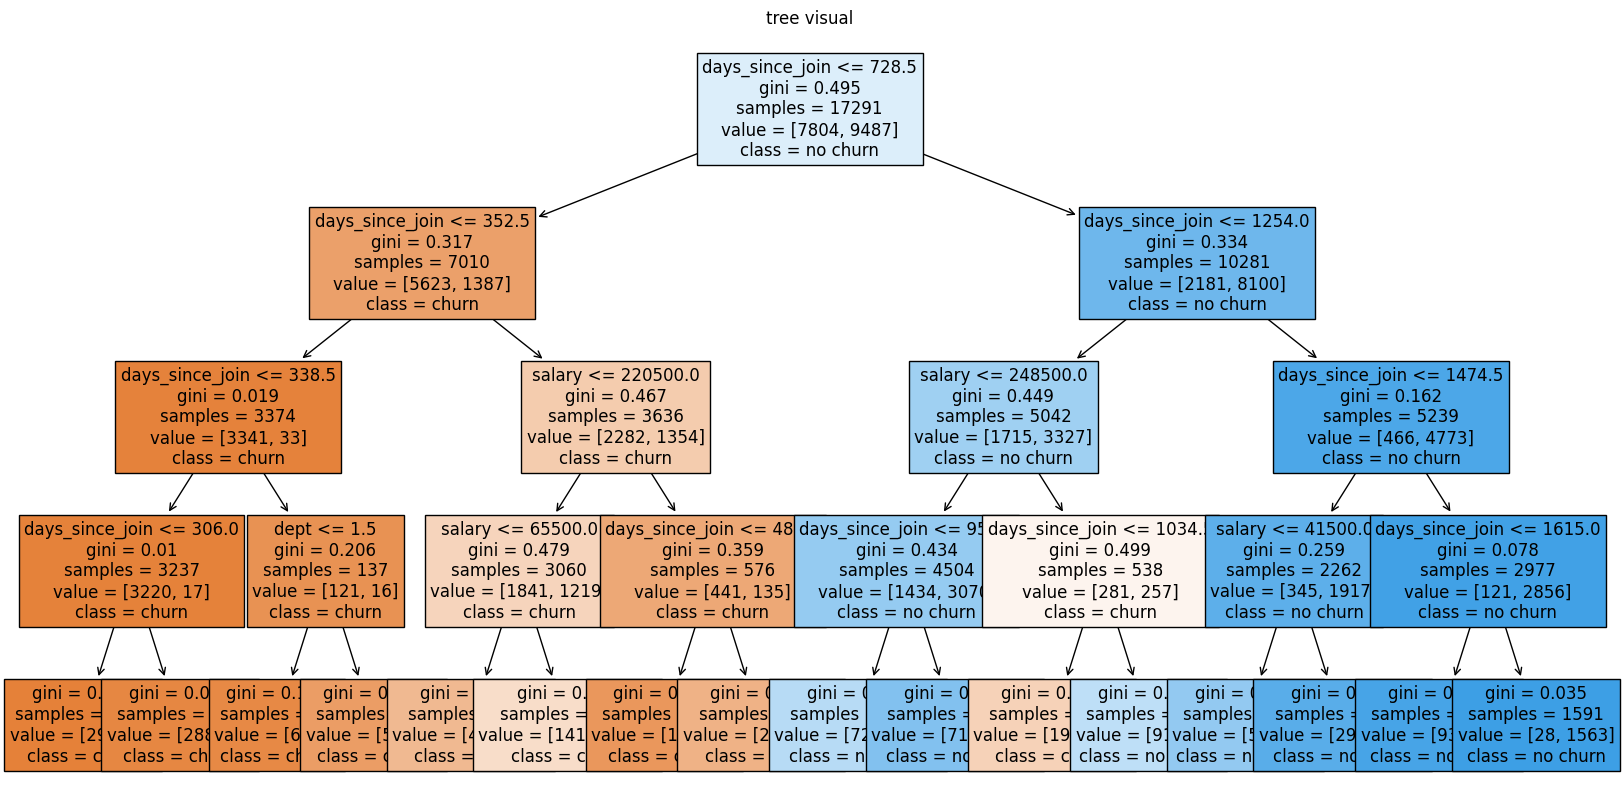

In [38]:
plt.figure(figsize=(20,10))
plot_tree(clf,feature_names=X.columns,class_names=["churn","no churn"],filled=True,fontsize=12)
plt.title("tree visual")
plt.show()

In [39]:
importances=clf.feature_importances_
feature_importance=pd.DataFrame({
    "feature":X.columns,
    "importace":importances
}).sort_values(by="importace")
print(feature_importance)

           feature  importace
0       company_id   0.000000
2        seniority   0.000000
1             dept   0.000279
3           salary   0.022783
4  days_since_join   0.976938


# findings
Join time length: most importance by the model, also through the graph which indicates that most churn happened around 1yr after join, which make sense since it may due to bonus/compensation dates or stay for at least a year to add to profile experience.  


salary:Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.
salary is also the second most import feature in model. 

Company or seniority play almost no rule in decision makeing accroding to model findings
